In [ ]:
import numpy as np
from collections import OrderedDict
import tensorflow as tf
from PIL import Image
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tifffile import imread
from tifffile import TiffWriter

In [ ]:
class N2V(tf.keras.layers.Layer):
  def __init__(self, n_f, beta=1., **kwargs):
    super().__init__(**kwargs)

    self.beta = beta
    self.n_f = n_f

    mask_cov = (np.ones((self.n_f, self.n_f)) - np.eye((self.n_f))).astype(np.float32)
    mask_var = np.eye((self.n_f)).astype(np.float32)

    self.mask_cov = tf.constant(mask_cov)
    self.mask_var = tf.constant(mask_var)

  def build(self, input_shape):
    # print(input_shape)
    d, h, w, n_c = input_shape[1], input_shape[2], input_shape[3], input_shape[4]
    #print(b, h, w, n_c)
    self.n = self.add_weight(initializer=tf.keras.initializers.HeNormal() ,shape=(1, 1, 1, n_c),name='n',dtype=tf.float32)
    self.f = self.add_weight(initializer=tf.keras.initializers.HeNormal(),shape=(d, h, w, self.n_f),name='f',dtype=tf.float32)
    self.m = self.add_weight(initializer=tf.keras.initializers.HeNormal(),shape=(self.n_f, n_c),name='m',dtype=tf.float32)
    super().build(input_shape)

  def rec_loss(self, C):
    Y = tf.matmul(self.f, self.m**2)
    #print(Y)
    Y += self.n
    
    diff = C - Y
    reconstruction_loss = tf.reduce_mean(tf.abs(diff))
    return reconstruction_loss

  def ort_loss(self):
    # average_F = tf.math.reduce_mean(self.f,axis=0,keepdims=True)
    # average_F = tf.math.reduce_mean(self.f,axis=1,keepdims=True)
    # F_centered = self.f - average_F
    
    f_flat = tf.reshape(self.f, shape=(-1, self.n_f))
    average_F = tf.math.reduce_mean(f_flat,axis=0,keepdims=True)
    F_centered = f_flat - average_F
    cov = tfp.stats.covariance(F_centered)

    cov_masked = tf.multiply(cov, self.mask_cov)
    var_masked = tf.multiply(cov, self.mask_var)
    # print(tf.shape(cov_masked))
    orthogonality_loss = tf.reduce_sum(tf.abs(cov_masked))

    unity_var_loss = tf.reduce_sum((var_masked-self.mask_var)**2)

    return self.beta * (orthogonality_loss + unity_var_loss)

  def call(self, C):
    reconstruction_loss = self.rec_loss(C)
    orthogonality_loss = self.ort_loss()
    loss = reconstruction_loss + orthogonality_loss
    #print(loss.shape)

    return reconstruction_loss, orthogonality_loss

In [ ]:
path = r'/content/drive/MyDrive/data/2PM data/frame_con/combined_image.tif'
#CC = np.array(Image.open(path).convert('L')).astype(np.float32)[np.newaxis]/255.
#CC = imread(path).astype(np.float32)[np.newaxis]/255.
CC = imread(path).astype(np.float32)
CC -= CC.mean(axis=(0, 1, 2), keepdims=True)
CC /= CC.std(axis=(0, 1, 2), keepdims=True)
CC = CC[np.newaxis]
print(CC.shape)

(1, 111, 512, 512, 2)


In [ ]:
n_f = 3
C = tf.keras.layers.Input(name='C', dtype=tf.float32, shape=(CC.shape[1:]))
layer = N2V(n_f=n_f, beta=1)
loss = layer(C)
print(C.shape, loss)

(None, 111, 512, 512, 2) (<KerasTensor: shape=() dtype=float32 (created by layer 'n2v_10')>, <KerasTensor: shape=() dtype=float32 (created by layer 'n2v_10')>)


In [ ]:
model = tf.keras.Model(inputs=C, outputs=loss)

In [ ]:
def loss_f(true_y, y):
    return y

def loss_dummy(true_y, y):
    return 0

optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss=[loss_f, loss_f])
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C (InputLayer)              [(None, 111, 512, 512, 2  0         
                             )]                                  
                                                                 
 n2v_10 (N2V)                ((),                      87293960  
                              ())                                
                                                                 
Total params: 87,293,960
Trainable params: 87,293,960
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lbl = lbl=np.array([0.], dtype=np.float32)
hist = model.fit(x=CC, y=lbl, batch_size=1, epochs=200)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 4.1184 - n2v_10_loss: 1.1184 - n2v_10_1_loss: 3.0000
Epoch 2/200
1/1 [==============================] - 0s 228ms/step - loss: 4.1145 - n2v_10_loss: 1.1145 - n2v_10_1_loss: 3.0000
Epoch 3/200
1/1 [==============================] - 0s 290ms/step - loss: 4.1105 - n2v_10_loss: 1.1105 - n2v_10_1_loss: 3.0000
Epoch 4/200
1/1 [==============================] - 0s 228ms/step - loss: 4.1066 - n2v_10_loss: 1.1066 - n2v_10_1_loss: 3.0000
Epoch 5/200
1/1 [==============================] - 0s 222ms/step - loss: 4.1026 - n2v_10_loss: 1.1026 - n2v_10_1_loss: 3.0000
Epoch 6/200
1/1 [==============================] - 0s 216ms/step - loss: 4.0986 - n2v_10_loss: 1.0986 - n2v_10_1_loss: 3.0000
Epoch 7/200
1/1 [==============================] - 0s 216ms/step - loss: 4.0945 - n2v_10_loss: 1.0945 - n2v_10_1_loss: 3.0000
Epoch 8/200
1/1 [==============================] - 0s 215ms/step - loss: 4.0905 - n2v_10_loss: 1.0905 - n2v_10_1_loss: 3.

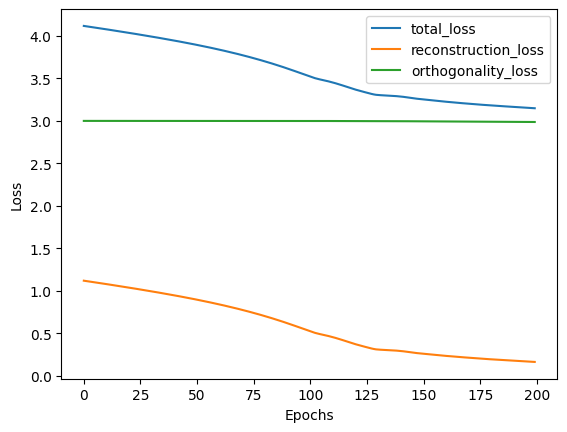

In [ ]:
loss_names = list(hist.history.keys())
loss, loss_0, loss_1 = [hist.history[name] for name in loss_names]

plt.plot(loss,label='total_loss')
plt.plot(loss_0,label='reconstruction_loss')
plt.plot(loss_1,label='orthogonality_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
optimizer.lr.assign(0.0005)
hist2 = model.fit(x=CC, y=lbl, batch_size=1, epochs=200)

Epoch 1/200
1/1 [==============================] - 0s 382ms/step - loss: 3.1474 - n2v_10_loss: 0.1604 - n2v_10_1_loss: 2.9869
Epoch 2/200
1/1 [==============================] - 0s 321ms/step - loss: 3.1471 - n2v_10_loss: 0.1602 - n2v_10_1_loss: 2.9869
Epoch 3/200
1/1 [==============================] - 0s 294ms/step - loss: 3.1468 - n2v_10_loss: 0.1599 - n2v_10_1_loss: 2.9869
Epoch 4/200
1/1 [==============================] - 0s 373ms/step - loss: 3.1465 - n2v_10_loss: 0.1596 - n2v_10_1_loss: 2.9869
Epoch 5/200
1/1 [==============================] - 0s 270ms/step - loss: 3.1461 - n2v_10_loss: 0.1593 - n2v_10_1_loss: 2.9869
Epoch 6/200
1/1 [==============================] - 0s 243ms/step - loss: 3.1458 - n2v_10_loss: 0.1589 - n2v_10_1_loss: 2.9869
Epoch 7/200
1/1 [==============================] - 0s 403ms/step - loss: 3.1455 - n2v_10_loss: 0.1586 - n2v_10_1_loss: 2.9869
Epoch 8/200
1/1 [==============================] - 0s 238ms/step - loss: 3.1452 - n2v_10_loss: 0.1584 - n2v_10_1_loss:

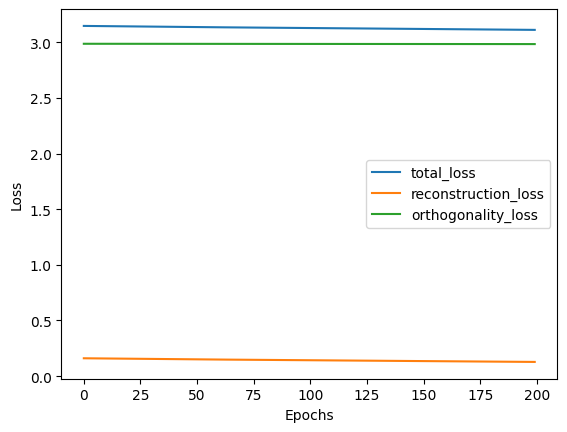

In [ ]:
loss_names = list(hist2.history.keys())
loss, loss_0, loss_1 = [hist2.history[name] for name in loss_names]

plt.plot(loss,label='total_loss')
plt.plot(loss_0,label='reconstruction_loss')
plt.plot(loss_1,label='orthogonality_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
layer.rec_loss(CC)

<tf.Tensor: shape=(), dtype=float32, numpy=0.12751655>

In [ ]:
layer.ort_loss()

<tf.Tensor: shape=(), dtype=float32, numpy=2.9841368>

In [ ]:
n = layer.n
f = layer.f
m = layer.m

In [ ]:
f_numpy = f.numpy()

In [ ]:
f_numpy_flat = f_numpy.reshape((-1, 3)).T
cov = np.cov(f_numpy_flat)
print(cov)

[[ 0.00224071  0.00304698  0.00117562]
 [ 0.00304698  0.00659108 -0.00166301]
 [ 0.00117562 -0.00166301  0.00502258]]


In [ ]:
for i in range(f_numpy.shape[-1]):
  with TiffWriter(r'/content/drive/MyDrive/data/2PM data/frame_con/'+f'result21_{i}.tif') as tif:
    ch_i_img = f_numpy[..., i].copy()
    ch_i_img -= ch_i_img.min()
    ch_i_img /= ch_i_img.max()
    ch_i_img *= (2**16 - 1)
    ch_i_img = ch_i_img.astype(np.uint16)
    
    tif.save(ch_i_img)
    # for p in range(len(ch_i_img)):
    #     frame = ch_i_img[p]
    # for frame in ch_i_img:
    #     im = Image.fromarray(frame)
        

        #imlist = []
        #for m in frame:
          #imlist.append(Image.fromarray(m))
          
        #imlist[0].save(f'result4_{i}.tif', compression="tiff_deflate", save_all=True,append_images=imlist[1:])

<ipython-input-177-1e639995114d>:9: DeprecationWarning: <tifffile.TiffWriter.save> is deprecated. Use TiffWriter.write
  tif.save(ch_i_img)


In [ ]:
result = imread(r"/content/result6_0.tif")
print(result.shape)

(111, 512, 512)


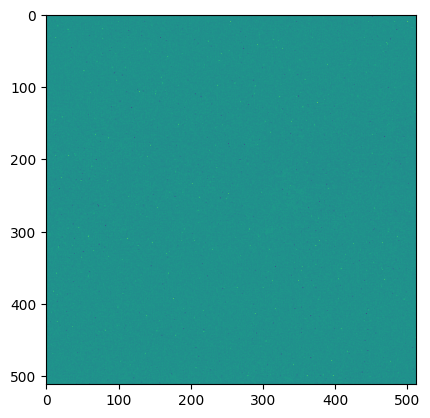

In [ ]:
plt.imshow(f[110, ..., 0])

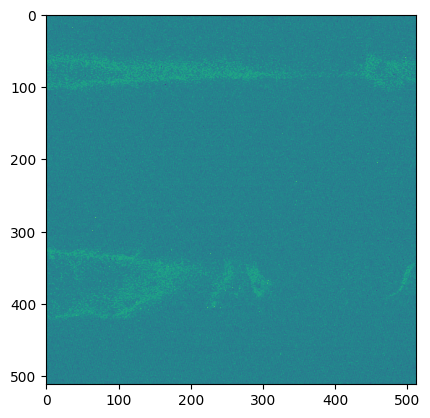

In [ ]:
plt.imshow(f[0, ..., 1])

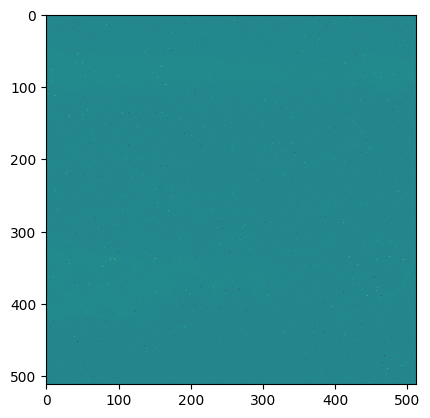

In [ ]:
plt.imshow(f[0, ..., 2])

In [ ]:
m**2

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[4.9903221e+00, 1.3415623e-04],
       [4.0967375e-01, 4.2088060e+00],
       [4.0556436e+00, 2.1265766e-03]], dtype=float32)>